In [1]:
versioninfo()

Julia Version 1.10.2
Commit bd47eca2c8 (2024-03-01 10:14 UTC)
Build Info:
  Official https://julialang.org/ release
Platform Info:
  OS: Windows (x86_64-w64-mingw32)
  CPU: 6 × AMD Ryzen 5 4500U with Radeon Graphics         
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-15.0.7 (ORCJIT, znver2)
Threads: 1 default, 0 interactive, 1 GC (on 6 virtual cores)
Environment:
  JULIA_NUM_THREADS = 


In [1]:
import Pkg
Pkg.add("SDDP")
Pkg.add("HiGHS")
Pkg.add("Plots")

    Updating registry at `C:\Users\matsz\.julia\registries\General.toml`
   Resolving package versions...
  No Changes to `C:\Users\matsz\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\matsz\.julia\environments\v1.10\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\matsz\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\matsz\.julia\environments\v1.10\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\matsz\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\matsz\.julia\environments\v1.10\Manifest.toml`


In [12]:
import Pkg
Pkg.add("Mustache")

    Updating registry at `C:\Users\matsz\.julia\registries\General.toml`
   Resolving package versions...
   Installed TimerOutputs ────────────── v0.5.24
   Installed DiffEqBase ──────────────── v6.151.2
   Installed Unitful ─────────────────── v1.20.0
   Installed TaylorSeries ────────────── v0.17.7
   Installed BandedMatrices ──────────── v1.7.2
   Installed RecursiveArrayTools ─────── v3.22.0
   Installed StaticArrays ────────────── v1.9.4
   Installed SentinelArrays ──────────── v1.4.3
   Installed PlotThemes ──────────────── v3.2.0
   Installed Rmath_jll ───────────────── v0.4.2+0
   Installed FreeType2_jll ───────────── v2.13.2+0
   Installed TranscodingStreams ──────── v0.10.9
   Installed libaom_jll ──────────────── v3.9.0+0
   Installed ArrayLayouts ────────────── v1.9.3
   Installed DataPipes ───────────────── v0.3.16
   Installed MathOptInterface ────────── v1.30.0
   Installed Mustache ────────────────── v1.0.19
   Installed ZMQ ─────────────────────── v1.2.5
   Installed 

In [1]:
using SDDP, HiGHS, Statistics, DataFrames, Plots, XLSX, Mustache, PrettyTables

In [2]:
module Temp
    struct GoalsData3
        minimum_limit:: Vector{Float64}
        acceptable_limit:: Vector{Float64}
        desired_limit::Vector{Float64}
        inflows:: Vector{Float64}
        minimum_utility:: Vector{Float32}
        acceptable_utility:: Vector{Float32}
        desired_utility:: Vector{Float32}
        above_desired_utility:: Vector{Float32}
        initial_wealth:: Float64
        provision:: Float32
    end
end

Main.Temp

In [21]:
data_source = DataFrame(XLSX.readtable("./goal_data.xlsx", "goal_data")) 
data = round.(data_source[1:26,:],digits=3)

Row,t,minimum_limit,acceptable_limit,desired_limit,inflows,priority,minimum_utility,acceptable_utility,desired_utility,above_desired_utility
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1.0,6.0,8.0,9.0,0.0,0.04,0.167,0.1,0.04,0.001
2,2.0,6.0,8.0,9.0,11.0,0.04,0.167,0.1,0.04,0.001
3,3.0,6.0,8.0,9.0,11.0,0.04,0.167,0.1,0.04,0.001
4,4.0,6.0,8.0,9.0,11.0,0.04,0.167,0.1,0.04,0.001
5,5.0,6.0,8.0,9.0,11.0,0.04,0.167,0.1,0.04,0.001
6,6.0,6.0,8.0,9.0,11.0,0.04,0.167,0.1,0.04,0.001
7,7.0,6.0,8.0,9.0,11.0,0.04,0.167,0.1,0.04,0.001
8,8.0,6.0,8.0,9.0,11.0,0.04,0.167,0.1,0.04,0.001
9,9.0,6.0,8.0,9.0,11.0,0.04,0.167,0.1,0.04,0.001


In [35]:
model_data = Temp.GoalsData3(
    data.minimum_limit,
    data.acceptable_limit,
    data.desired_limit,
    data.inflows,
    data.minimum_utility,
    data.acceptable_utility,
    data.desired_utility,
    data.above_desired_utility,
    165.0,
    0.0029
    )


Main.Temp.GoalsData3([6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 66.0  …  6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 96.0], [8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 98.0  …  8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 143.0], [9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 159.0  …  9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 259.0], [0.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0  …  11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0], Float32[0.167, 0.167, 0.167, 0.167, 0.167, 0.167, 0.167, 0.167, 0.167, 0.379  …  0.167, 0.167, 0.167, 0.167, 0.167, 0.167, 0.167, 0.167, 0.167, 0.26], Float32[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.156  …  0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.106], Float32[0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.016  …  0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.009], Float32[0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001  …  0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 

In [186]:
graph3 = SDDP.MarkovianGraph(
    Array{Float64,2}[
        [1.0]',
        [0.1065 0.787 0.1065],
        [0.1065 0.787 0.1065; 0.1065 0.787 0.1065; 0.1065 0.787 0.1065],
        [0.1065 0.787 0.1065; 0.1065 0.787 0.1065; 0.1065 0.787 0.1065],
        [0.1065 0.787 0.1065; 0.1065 0.787 0.1065; 0.1065 0.787 0.1065],
        [0.1065 0.787 0.1065; 0.1065 0.787 0.1065; 0.1065 0.787 0.1065],
        [0.1065 0.787 0.1065; 0.1065 0.787 0.1065; 0.1065 0.787 0.1065],
        [0.1065 0.787 0.1065; 0.1065 0.787 0.1065; 0.1065 0.787 0.1065],
        [0.1065 0.787 0.1065; 0.1065 0.787 0.1065; 0.1065 0.787 0.1065],
        [0.1065 0.787 0.1065; 0.1065 0.787 0.1065; 0.1065 0.787 0.1065],
        [0.1065 0.787 0.1065; 0.1065 0.787 0.1065; 0.1065 0.787 0.1065],
        [0.1065 0.787 0.1065; 0.1065 0.787 0.1065; 0.1065 0.787 0.1065],
        [0.1065 0.787 0.1065; 0.1065 0.787 0.1065; 0.1065 0.787 0.1065]                             
                              
    ]            
)

Root
 (0, 1)
Nodes
 (1, 1)
 (2, 1)
 (2, 2)
 (2, 3)
 (3, 1)
 (3, 2)
 (3, 3)
 (4, 1)
 (4, 2)
 (4, 3)
 (5, 1)
 (5, 2)
 (5, 3)
 (6, 1)
 (6, 2)
 (6, 3)
 (7, 1)
 (7, 2)
 (7, 3)
 (8, 1)
 (8, 2)
 (8, 3)
 (9, 1)
 (9, 2)
 (9, 3)
 (10, 1)
 (10, 2)
 (10, 3)
 (11, 1)
 (11, 2)
 (11, 3)
 (12, 1)
 (12, 2)
 (12, 3)
 (13, 1)
 (13, 2)
 (13, 3)
Arcs
 (0, 1) => (1, 1) w.p. 1.0
 (1, 1) => (2, 1) w.p. 0.1065
 (1, 1) => (2, 2) w.p. 0.787
 (1, 1) => (2, 3) w.p. 0.1065
 (2, 1) => (3, 1) w.p. 0.1065
 (2, 1) => (3, 2) w.p. 0.787
 (2, 1) => (3, 3) w.p. 0.1065
 (2, 2) => (3, 1) w.p. 0.1065
 (2, 2) => (3, 2) w.p. 0.787
 (2, 2) => (3, 3) w.p. 0.1065
 (2, 3) => (3, 1) w.p. 0.1065
 (2, 3) => (3, 2) w.p. 0.787
 (2, 3) => (3, 3) w.p. 0.1065
 (3, 1) => (4, 1) w.p. 0.1065
 (3, 1) => (4, 2) w.p. 0.787
 (3, 1) => (4, 3) w.p. 0.1065
 (3, 2) => (4, 1) w.p. 0.1065
 (3, 2) => (4, 2) w.p. 0.787
 (3, 2) => (4, 3) w.p. 0.1065
 (3, 3) => (4, 1) w.p. 0.1065
 (3, 3) => (4, 2) w.p. 0.787
 (3, 3) => (4, 3) w.p. 0.1065
 (4, 1) => (5, 1) 

In [269]:
graph6 = SDDP.MarkovianGraph(
    Array{Float64,2}[
        [1.0]',
        [0.0275 0.1558 0.3577 0.3331 0.1258],      
        [0.0275 0.1558 0.3577 0.3331 0.1258; 0.0275 0.1558 0.3577 0.3331 0.1258; 0.0275 0.1558 0.3577 0.3331 0.1258; 0.0275 0.1558 0.3577 0.3331 0.1258; 0.0275 0.1558 0.3577 0.3331 0.1258],
        [0.0275 0.1558 0.3577 0.3331 0.1258; 0.0275 0.1558 0.3577 0.3331 0.1258; 0.0275 0.1558 0.3577 0.3331 0.1258; 0.0275 0.1558 0.3577 0.3331 0.1258; 0.0275 0.1558 0.3577 0.3331 0.1258],                     
        [0.0275 0.1558 0.3577 0.3331 0.1258; 0.0275 0.1558 0.3577 0.3331 0.1258; 0.0275 0.1558 0.3577 0.3331 0.1258; 0.0275 0.1558 0.3577 0.3331 0.1258; 0.0275 0.1558 0.3577 0.3331 0.1258], 
        [0.0275 0.1558 0.3577 0.3331 0.1258; 0.0275 0.1558 0.3577 0.3331 0.1258; 0.0275 0.1558 0.3577 0.3331 0.1258; 0.0275 0.1558 0.3577 0.3331 0.1258; 0.0275 0.1558 0.3577 0.3331 0.1258]                     
    ]            
)

Root
 (0, 1)
Nodes
 (1, 1)
 (2, 1)
 (2, 2)
 (2, 3)
 (2, 4)
 (2, 5)
 (3, 1)
 (3, 2)
 (3, 3)
 (3, 4)
 (3, 5)
 (4, 1)
 (4, 2)
 (4, 3)
 (4, 4)
 (4, 5)
 (5, 1)
 (5, 2)
 (5, 3)
 (5, 4)
 (5, 5)
 (6, 1)
 (6, 2)
 (6, 3)
 (6, 4)
 (6, 5)
Arcs
 (0, 1) => (1, 1) w.p. 1.0
 (1, 1) => (2, 1) w.p. 0.0275
 (1, 1) => (2, 2) w.p. 0.1558
 (1, 1) => (2, 3) w.p. 0.3577
 (1, 1) => (2, 4) w.p. 0.3331
 (1, 1) => (2, 5) w.p. 0.1258
 (2, 1) => (3, 1) w.p. 0.0275
 (2, 1) => (3, 2) w.p. 0.1558
 (2, 1) => (3, 3) w.p. 0.3577
 (2, 1) => (3, 4) w.p. 0.3331
 (2, 1) => (3, 5) w.p. 0.1258
 (2, 2) => (3, 1) w.p. 0.0275
 (2, 2) => (3, 2) w.p. 0.1558
 (2, 2) => (3, 3) w.p. 0.3577
 (2, 2) => (3, 4) w.p. 0.3331
 (2, 2) => (3, 5) w.p. 0.1258
 (2, 3) => (3, 1) w.p. 0.0275
 (2, 3) => (3, 2) w.p. 0.1558
 (2, 3) => (3, 3) w.p. 0.3577
 (2, 3) => (3, 4) w.p. 0.3331
 (2, 3) => (3, 5) w.p. 0.1258
 (2, 4) => (3, 1) w.p. 0.0275
 (2, 4) => (3, 2) w.p. 0.1558
 (2, 4) => (3, 3) w.p. 0.3577
 (2, 4) => (3, 4) w.p. 0.3331
 (2, 4) => (3, 5) w.p

In [49]:
graph25 = SDDP.MarkovianGraph(
    Array{Float64,2}[
        [1.0]',
        [0.0486 0.1908 0.3483 0.2956 0.1167],
        [0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167],
        [0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167],
        [0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167],
        [0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167],
        [0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167],
        [0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167],
        [0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167],
        [0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167],
        [0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167],
        [0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167],
        [0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167],
        [0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167],
        [0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167],
        [0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167],
        [0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167],
        [0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167],
        [0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167],
        [0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167],
        [0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167],
        [0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167],
        [0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167],
        [0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167],
        [0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167],
        [0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167; 0.0486 0.1908 0.3483 0.2956 0.1167],
                              
    ]            
)

Root
 (0, 1)
Nodes
 (1, 1)
 (2, 1)
 (2, 2)
 (2, 3)
 (2, 4)
 (2, 5)
 (3, 1)
 (3, 2)
 (3, 3)
 (3, 4)
 (3, 5)
 (4, 1)
 (4, 2)
 (4, 3)
 (4, 4)
 (4, 5)
 (5, 1)
 (5, 2)
 (5, 3)
 (5, 4)
 (5, 5)
 (6, 1)
 (6, 2)
 (6, 3)
 (6, 4)
 (6, 5)
 (7, 1)
 (7, 2)
 (7, 3)
 (7, 4)
 (7, 5)
 (8, 1)
 (8, 2)
 (8, 3)
 (8, 4)
 (8, 5)
 (9, 1)
 (9, 2)
 (9, 3)
 (9, 4)
 (9, 5)
 (10, 1)
 (10, 2)
 (10, 3)
 (10, 4)
 (10, 5)
 (11, 1)
 (11, 2)
 (11, 3)
 (11, 4)
 (11, 5)
 (12, 1)
 (12, 2)
 (12, 3)
 (12, 4)
 (12, 5)
 (13, 1)
 (13, 2)
 (13, 3)
 (13, 4)
 (13, 5)
 (14, 1)
 (14, 2)
 (14, 3)
 (14, 4)
 (14, 5)
 (15, 1)
 (15, 2)
 (15, 3)
 (15, 4)
 (15, 5)
 (16, 1)
 (16, 2)
 (16, 3)
 (16, 4)
 (16, 5)
 (17, 1)
 (17, 2)
 (17, 3)
 (17, 4)
 (17, 5)
 (18, 1)
 (18, 2)
 (18, 3)
 (18, 4)
 (18, 5)
 (19, 1)
 (19, 2)
 (19, 3)
 (19, 4)
 (19, 5)
 (20, 1)
 (20, 2)
 (20, 3)
 (20, 4)
 (20, 5)
 (21, 1)
 (21, 2)
 (21, 3)
 (21, 4)
 (21, 5)
 (22, 1)
 (22, 2)
 (22, 3)
 (22, 4)
 (22, 5)
 (23, 1)
 (23, 2)
 (23, 3)
 (23, 4)
 (23, 5)
 (24, 1)
 (24, 2)
 (24,

In [59]:
function asset_management_alm(data:: Temp.GoalsData3)
  
    model = SDDP.PolicyGraph(
        graph25,
        lower_bound = -97,
        optimizer = HiGHS.Optimizer,
    ) do subproblem, index
        (stage, markov_state) = index
        r_stock = [0.8 0.9 1.01 1.14 1.28] #[0.82 0.92 1.04 1.16 1.31] #[0.72 0.95 1.26 1.67 2.21] #       
        r_bonds = [1.015]
        @variable(subproblem, stocks >= 0, SDDP.State, initial_value = 0.0)
        @variable(subproblem, bonds >= 0, SDDP.State, initial_value = 0.0)

        @variable(subproblem, bonds_buy >= 0)
        @variable(subproblem, bonds_sell >= 0)
        @variable(subproblem, stocks_buy >= 0)
        @variable(subproblem, stocks_sell >= 0)                     
         
        
        @variable(subproblem, consumption >=0)
        
        @variable(subproblem, 0 <= minimum<= data.minimum_limit[stage])
        @variable(subproblem, 0 <= acceptable <= data.acceptable_limit[stage] - data.minimum_limit[stage])
        @variable(subproblem, 0 <= desired <= data.desired_limit[stage] - data.acceptable_limit[stage])
        @variable(subproblem, 0 <= above_desired)
        @constraint(subproblem, minimum + acceptable + desired + above_desired == consumption)
                     
        if stage == 1
            @constraint(subproblem, bonds_buy - bonds_sell == bonds.out)
            @constraint(subproblem, stocks_buy - stocks_sell == stocks.out)
            @constraint(subproblem, stocks_buy*(1+data.provision) + bonds_buy*(1+data.provision) + consumption == data.initial_wealth) 
                                           
            @stageobjective(subproblem, -(data.minimum_utility[stage] * minimum + data.acceptable_utility[stage] * acceptable + data.desired_utility[stage] * desired + data.above_desired_utility[stage] * above_desired))
            
        elseif 1 < stage 
            @constraint(
                subproblem,
                r_stock[markov_state] * stocks.in + stocks_buy - stocks_sell== stocks.out)

            @constraint(
                subproblem,
                r_bonds[1] * bonds.in + bonds_buy - bonds_sell== bonds.out)

            @constraint(subproblem, stocks_buy*(1+data.provision) - stocks_sell*(1+data.provision) + bonds_buy*(1+data.provision) - bonds_sell*(1+data.provision) + consumption - data.inflows[stage] == 0) 

            @stageobjective(subproblem, -(data.minimum_utility[stage] * minimum + data.acceptable_utility[stage] * acceptable + data.desired_utility[stage] * desired + data.above_desired_utility[stage] * above_desired))
        
        end
    end
    SDDP.train(model; iteration_limit = 1200, log_frequency = 50)
    
   #@test SDDP.calculate_bound(model) ≈ 1.514 atol = 1e-4
    return model
end

model = asset_management_alm(model_data)


-------------------------------------------------------------------
         SDDP.jl (c) Oscar Dowson and contributors, 2017-23
-------------------------------------------------------------------
problem
  nodes           : 126
  state variables : 2
  scenarios       : 2.98023e+17
  existing cuts   : false
options
  solver          : serial mode
  risk measure    : SDDP.Expectation()
  sampling scheme : SDDP.InSampleMonteCarlo
subproblem structure
  VariableRef                             : [14, 14]
  AffExpr in MOI.EqualTo{Float64}         : [4, 4]
  VariableRef in MOI.GreaterThan{Float64} : [12, 12]
  VariableRef in MOI.LessThan{Float64}    : [3, 4]
numerical stability report
  matrix range     [8e-01, 1e+00]
  objective range  [1e-03, 1e+00]
  bounds range     [1e+00, 1e+02]
  rhs range        [1e+01, 2e+02]
-------------------------------------------------------------------
 iteration    simulation      bound        time (s)     solves  pid
-----------------------------------------

A policy graph with 126 nodes.
 Node indices: (1, 1), ..., (26, 5)


In [60]:
simulations = SDDP.simulate(
    # The trained model to simulate.
    model,
    # The number of replications.
    2000,
    # A list of names to record the values of.
    [:stocks, :bonds, :minimum, :acceptable, :desired, :above_desired, :consumption],
    skip_undefined_variables=true
)

println("Lower bounds", SDDP.calculate_bound(model))

objectives = map(simulations) do simulation
    return sum(stage[:stage_objective] for stage in simulation)
end

μ, ci = SDDP.confidence_interval(objectives)
println("Confidence interval: ", μ, " ± ", ci)

Lower bounds-91.0617683174947
Confidence interval: -91.01013120416808 ± 0.054950704931223116


In [291]:
plt = SDDP.SpaghettiPlot(simulations)

SDDP.add_spaghetti(plt; title = "Stocks") do data
    return data[:stocks].out
end

SDDP.plot(plt)


In [280]:
plt = SDDP.SpaghettiPlot(simulations)

SDDP.add_spaghetti(plt; title = "Consumption") do data
    return data[:consumption]
end

SDDP.plot(plt)

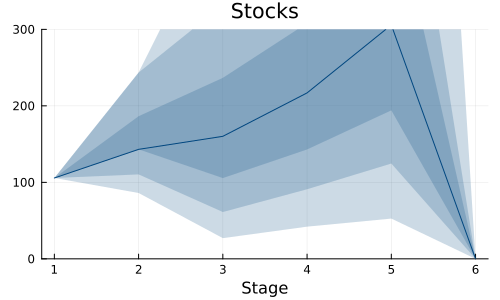

In [292]:
import Plots

Plots.plot(
    SDDP.publication_plot(simulations, title = "Stocks") do data
        return data[:stocks].out
    end,
  #  SDDP.publication_plot(simulations, title = "Bonds") do data
  #      return data[:bonds]
  #  end;
    xlabel = "Stage",
    ylims = (0, 300),
    layout = (1, 2),
)

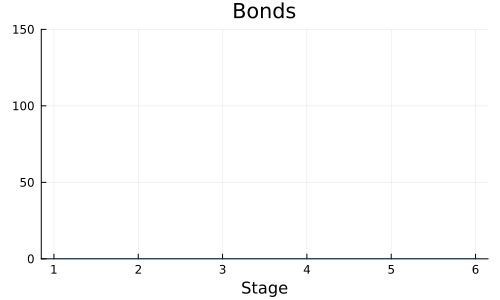

In [293]:
Plots.plot(
    SDDP.publication_plot(simulations, title = "Bonds") do data
        return data[:bonds].out
    end,
  #  SDDP.publication_plot(simulations, title = "Bonds") do data
  #      return data[:bonds]
  #  end;
    xlabel = "Stage",
    ylims = (0, 150),
    layout = (1, 2),
)

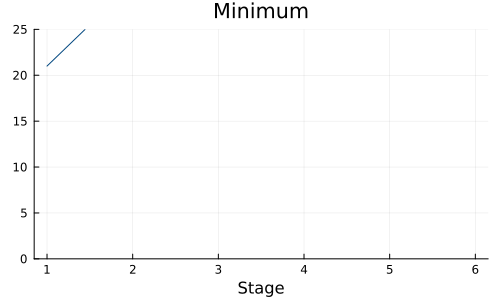

In [294]:
Plots.plot(
    SDDP.publication_plot(simulations, title = "Minimum") do data
        return data[:minimum]
    end,
  #  SDDP.publication_plot(simulations, title = "Bonds") do data
  #      return data[:bonds]
  #  end;
    xlabel = "Stage",
    ylims = (0, 25),
    layout = (1, 2),
)

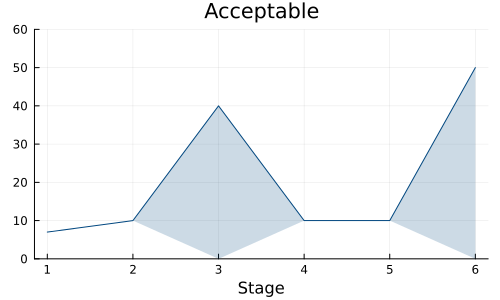

In [295]:
Plots.plot(
    SDDP.publication_plot(simulations, title = "Acceptable") do data
        return data[:acceptable]
    end,
  #  SDDP.publication_plot(simulations, title = "Bonds") do data
  #      return data[:bonds]
  #  end;
    xlabel = "Stage",
    ylims = (0, 60),
    layout = (1, 2),
)

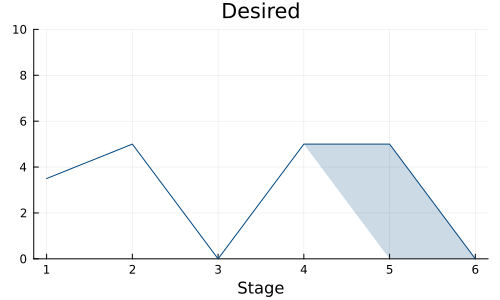

In [296]:
Plots.plot(
    SDDP.publication_plot(simulations, title = "Desired") do data
        return data[:desired]
    end,
  #  SDDP.publication_plot(simulations, title = "Bonds") do data
  #      return data[:bonds]
  #  end;
    xlabel = "Stage",
    ylims = (0, 10),
    layout = (1, 2),
)

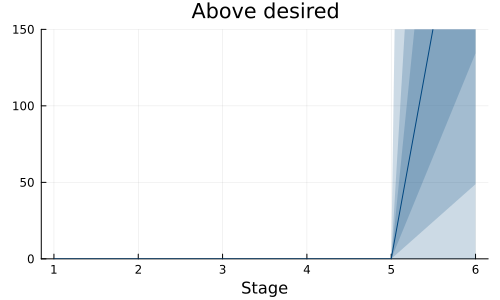

In [297]:
Plots.plot(
    SDDP.publication_plot(simulations, title = "Above desired") do data
        return data[:above_desired]
    end,
  #  SDDP.publication_plot(simulations, title = "Bonds") do data
  #      return data[:bonds]
  #  end;
    xlabel = "Stage",
    ylims = (0, 150),
    layout = (1, 2),
)

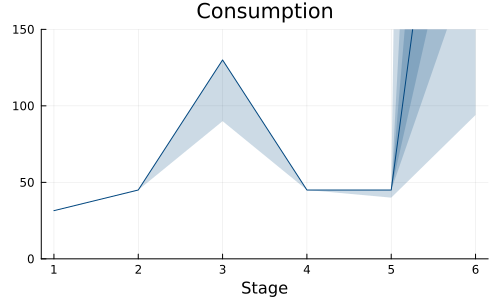

In [298]:
Plots.plot(
    SDDP.publication_plot(simulations, title = "Consumption") do data
        return data[:consumption]
    end,
  #  SDDP.publication_plot(simulations, title = "Bonds") do data
  #      return data[:bonds]
  #  end;
    xlabel = "Stage",
    ylims = (0, 150),
    layout = (1, 2),
)

In [13]:
function calculate_perc(data, perc = [0.05, 0.25, 0.5, 0.75, 0.95])
    n_scenarios, n_stages = size(data)
    
    result = zeros(n_stages, length(perc)) 

    for t in 1:n_stages
       result[t,:] = quantile(data[:,t], perc)
    end

    return DataFrame(round.(result,digits=2),string.(perc))
  
end

calculate_perc (generic function with 2 methods)

In [61]:
n_scenarios = 2000
n_stages = 26
bonds = zeros(n_scenarios,n_stages)
stocks = zeros(n_scenarios,n_stages)
consumption = zeros(n_scenarios,n_stages)

for (i, scenario) in enumerate(simulations)
    bonds[i,:] = [node[:bonds].out for node in scenario]
    stocks[i,:] = [node[:stocks].out for node in scenario]
    consumption[i,:] = [node[:consumption] for node in scenario]
end




Row,0.05,0.25,0.5,0.75,0.95
,Float64,Float64,Float64,Float64,Float64
1,155.55,155.55,155.55,155.55,155.55
2,127.43,159.12,159.12,178.74,199.87
3,130.26,148.3,165.71,187.22,224.03
4,133.34,153.77,183.96,206.82,252.23
5,126.97,158.36,190.68,219.01,263.9
6,131.42,163.34,196.6,236.7,288.02
7,135.23,171.81,205.18,246.07,310.49
8,138.69,181.54,226.11,265.52,334.52
9,141.59,185.61,237.39,273.39,352.71


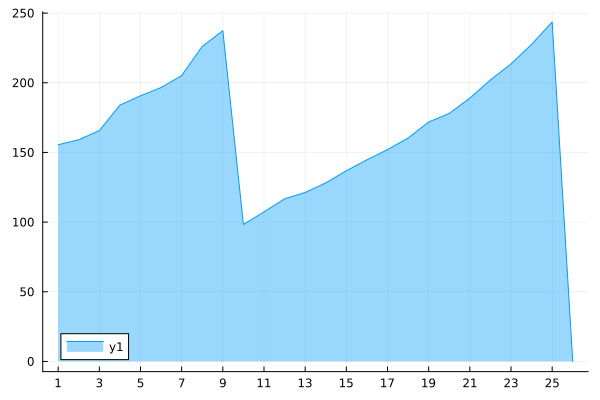

In [62]:
wealth = stocks .+ bonds

wealth_perc = calculate_perc(wealth)

display(wealth_perc)

areaplot(wealth_perc[:,3], fillalpha=0.4, xticks=1:2:n_stages)

Row,0.05,0.25,0.5,0.75,0.95
,Float64,Float64,Float64,Float64,Float64
1,0.97,0.97,0.97,0.97,0.97
2,0.77,0.83,0.86,0.86,1.0
3,0.76,0.84,0.86,0.92,1.0
4,0.69,0.76,0.85,0.89,0.94
5,0.67,0.76,0.83,0.92,1.0
6,0.6,0.71,0.83,0.92,1.0
7,0.52,0.66,0.78,0.95,1.0
8,0.41,0.55,0.73,1.0,1.0
9,0.36,0.44,0.61,1.0,1.0


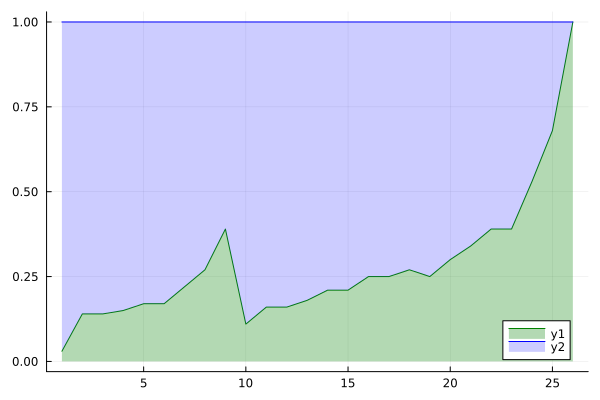

In [63]:
stocks_weight = stocks ./wealth

stocks_weight[:,end] .= 0

stocks_weight_perc = calculate_perc(stocks_weight)

display(stocks_weight_perc)


bonds_weight_perc = 1 .- stocks_weight_perc

areaplot(1:n_stages, [bonds_weight_perc[1:n_stages,3] stocks_weight_perc[1:n_stages,3]], seriescolor = [:green :blue], fillalpha = [0.3 0.2], zticks=1:1:n_stages)

In [64]:
calculate_perc(consumption)

Row,0.05,0.25,0.5,0.75,0.95
,Float64,Float64,Float64,Float64,Float64
1,9.0,9.0,9.0,9.0,9.0
2,9.0,9.0,9.0,9.0,9.0
3,9.0,9.0,9.0,9.0,9.0
4,9.0,9.0,9.0,9.0,9.0
5,9.0,9.0,9.0,9.0,9.0
6,9.0,9.0,9.0,9.0,9.0
7,9.0,9.0,9.0,9.0,9.0
8,8.0,9.0,9.0,9.0,9.0
9,8.0,9.0,9.0,9.0,9.0


In [65]:
minimum_limit = model_data.minimum_limit
acceptable_limit = model_data.acceptable_limit
desired_limit = model_data.desired_limit
limits = [minimum_limit, acceptable_limit, desired_limit]

goals_succes = zeros(n_stages,3)

for goal in 1:3
    goals_succes[:,goal] = [count(c -> (round(c,digits=1) >= limits[goal][t]), consumption[:,t]) /n_scenarios for t in 1:n_stages]
end

goals_succes = DataFrame(round.(goals_succes,digits=2), ["above minimum","above acceptable","above_desired"])

Row,above minimum,above acceptable,above_desired
,Float64,Float64,Float64
1,1.0,1.0,1.0
2,1.0,1.0,1.0
3,1.0,1.0,1.0
4,1.0,1.0,0.99
5,1.0,1.0,0.98
6,1.0,1.0,0.98
7,1.0,1.0,0.96
8,1.0,1.0,0.94
9,1.0,1.0,0.94


In [66]:
total_consumption = sum(consumption,dims=2)

total_consumption_perc = calculate_perc(total_consumption)


Row,0.05,0.25,0.5,0.75,0.95
,Float64,Float64,Float64,Float64,Float64
1,446.98,515.6,607.72,643.81,963.93


In [67]:
function print_sddp_report(template::String, input_data::DataFrame, wealth::DataFrame, stocks::DataFrame, goals_succes::DataFrame, total_consumption::DataFrame, report_name::String)

  tpl = open(io->read(io, String), template)
  
  report = Mustache.render(tpl, TITLE="A quick table", input_data=input_data, wealth=wealth, stocks=stocks, goals_succes=goals_succes, total_consumption=total_consumption)

  report_path = "c:\\Users\\matsz\\programowanie\\Optymalizacja_portfela\\julia_msp\\reports\\$(report_name).html"
  write(report_path, report)

  run(`$(ENV["COMSPEC"]) /c start $(report_path)`)
 
end

print_sddp_report("c:\\Users\\matsz\\programowanie\\Optymalizacja_portfela\\julia_msp\\reports\\tpl.html", data, wealth_perc, stocks_weight_perc, goals_succes, total_consumption_perc, "test_30.06.24_real_rates_il")

Process(`'C:\WINDOWS\system32\cmd.exe' /c start 'c:\Users\matsz\programowanie\Optymalizacja_portfela\julia_msp\reports\test_30.06.24_real_rates_il.html'`, ProcessExited(0))